# Image Understanding Final Project - Implementing GANS

In [1]:
import utils, torch, time, os, pickle
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from keras.datasets import fashion_mnist


Using TensorFlow backend.


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
batch_size=100
z_dim = 64
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'BAg', 'Ankle Boot')


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

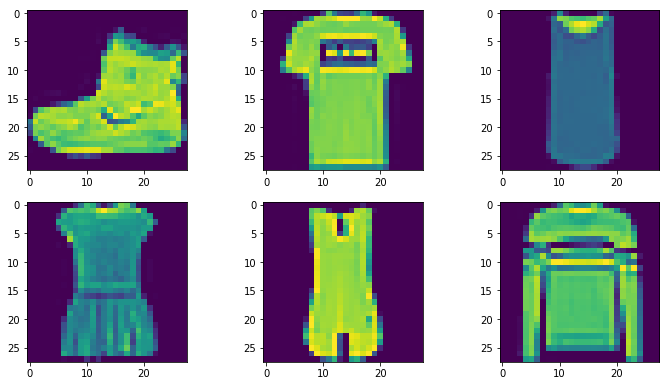

In [3]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network



In [4]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x
    
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
G_net = generator(input_dim=z_dim)
D_net = discriminator()
G_net.to(device)
D_net.to(device)
if device == 'cuda':
    G_net = torch.nn.DataParallel(G_net)
    D_net = torch.nn.DataParallel(D_net)
torch.backends.cudnn.benchmark = True

In [6]:
G_net
D_net

DataParallel(
  (module): discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=1, bias=True)
      (4): Sigmoid()
    )
  )
)

In [7]:
G_optimizer = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
D_optimizer = optim.Adam(D_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
criterion =  nn.BCELoss()


In [8]:
y_real_, y_fake_ = torch.ones(batch_size, 1), torch.zeros(batch_size, 1)
if device == 'cuda':
    y_real_,y_fake_ = y_real_.to(device), y_fake_.to(device)
# fixed noise
sample_z_ = torch.rand((batch_size, z_dim))

In [9]:
# sample_z_.shape

In [10]:
train_hist = {}
train_hist['D_loss'] = []
train_hist['G_loss'] = []
train_hist['D_loss_epoch'] = []
train_hist['G_loss_epoch'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []
epochs = 900
img = []

## Training

In [11]:
def train():
    D_net.train()
    print('training start!!')
    start_time = time.time()
    for epoch in range(epochs):
        G_net.train()
        epoch_start_time = time.time()
#     print(criterion)
#     training_loss = 0
#     train_correct = 0
#     lo = []
        for batch_idx, (data, target) in enumerate(train_loader):
        
            #==== Updating Discriminative Network=====#

            #==== Making Random Noise=====#
            z_ = torch.rand((batch_size, z_dim))
            data, target, z_ = data.to(device), target.to(device), z_.to(device)

            D_optimizer.zero_grad()

            #==== Forward Pass for Discriminator=====
            D_real = D_net(data)
            D_real_loss = criterion(D_real, y_real_)

            #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)
            D_fake_loss = criterion(D_fake, y_fake_)

            #==== Total Loss=====
            D_loss = D_real_loss + D_fake_loss
            train_hist['D_loss'].append(D_loss.item())

            #=====Backward Pass=======
            D_loss.backward()
            D_optimizer.step()

            #==== Updating Generative Network=====#

            G_optimizer.zero_grad()        
             #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)

            #==== Total Loss=====
            G_loss = criterion(D_fake, y_real_)
            train_hist['G_loss'].append(G_loss.item())
            #=====Backward Pass=======
            G_loss.backward()
            G_optimizer.step()

            if ((batch_idx + 1) % 100) == 0:
                print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
    ((epoch + 1), (batch_idx + 1), train_loader.dataset.__len__() // batch_size, D_loss.item(), G_loss.item()))

        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)            
        train_hist['G_loss_epoch'].append(np.mean(train_hist['G_loss']))
        train_hist['D_loss_epoch'].append(np.mean(train_hist['D_loss']))
        with torch.no_grad():
            visualize_results()

    train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']),
              epoch, train_hist['total_time'][0]))
    print("Training finish!... save training results")
    save()

def save():
    save_dir = "./models/"
    torch.save(G_net, os.path.join(save_dir,  '_G1.pkl'))
    torch.save(D_net, os.path.join(save_dir,'_D1.pkl'))
    torch.save(G.state_dict(), os.path.join(save_dir, self.model_name + '_G_state.pkl'))
    torch.save(D.state_dict(), os.path.join(save_dir, self.model_name + '_D_state.pkl'))
    np.save('./models/train_hist.npy', train_hist)
    np.save('./models/img.npy', img)
    
    
    with open(os.path.join(save_dir, '_history1.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)
        
    with open(os.path.join(save_dir, '_img1.pkl'), 'wb') as g:
        pickle.dump(img, g)
        
def load():
    save_dir = "./models/"
#     G_net =generator(input_dim=z_dim)
#     D_net = discriminator()
    G_net= torch.load(os.path.join(save_dir, '_G1.pkl'))
    D_net =torch.load(os.path.join(save_dir, '_D1.pkl'))
#     train_hist = np.load('./models/train_hist.npy')
#     img = np.load('./models/img.npy')
    with open(os.path.join(save_dir, '_history1.pkl'), 'rb') as f:
        train_hist = pickle.load(f)
    with open(os.path.join(save_dir, '_img1.pkl'), 'rb') as g:
        img = pickle.load(g)
        
def visualize_results(fix=True):
    G_net.eval()
#     sample_z_ = torch.rand((batch_size, z_dim))
    result_dir = "./results/"
#     print(sample_z_.shape)
    if fix:
        """ fixed noise """
        samples = G_net(sample_z_)
    else:
        """ random noise """
        sample_z = torch.rand((batch_size,z_dim))
        sample_z = sample_z.cuda()
        samples = G_net(sample_z)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    img.append(samples)
        

In [12]:
train()

training start!!
Epoch: [ 1] [ 100/ 600] D_loss: 1.15795219, G_loss: 0.87448943
Epoch: [ 1] [ 200/ 600] D_loss: 1.04576063, G_loss: 0.95423317
Epoch: [ 1] [ 300/ 600] D_loss: 1.09053063, G_loss: 1.02857399
Epoch: [ 1] [ 400/ 600] D_loss: 0.99547219, G_loss: 1.04556513
Epoch: [ 1] [ 500/ 600] D_loss: 0.96593320, G_loss: 1.09247875
Epoch: [ 1] [ 600/ 600] D_loss: 1.10850203, G_loss: 1.03397655
Epoch: [ 2] [ 100/ 600] D_loss: 1.01980281, G_loss: 1.20385361
Epoch: [ 2] [ 200/ 600] D_loss: 1.04731393, G_loss: 1.04652739
Epoch: [ 2] [ 300/ 600] D_loss: 1.09856772, G_loss: 1.11360538
Epoch: [ 2] [ 400/ 600] D_loss: 1.13214290, G_loss: 0.91241997
Epoch: [ 2] [ 500/ 600] D_loss: 1.04948068, G_loss: 1.08415365
Epoch: [ 2] [ 600/ 600] D_loss: 1.08704364, G_loss: 1.12248981
Epoch: [ 3] [ 100/ 600] D_loss: 1.11599064, G_loss: 1.13741827
Epoch: [ 3] [ 200/ 600] D_loss: 1.10338020, G_loss: 1.13724244
Epoch: [ 3] [ 300/ 600] D_loss: 1.11672330, G_loss: 1.09002173
Epoch: [ 3] [ 400/ 600] D_loss: 1.0499

Epoch: [22] [ 500/ 600] D_loss: 0.81166196, G_loss: 1.47312403
Epoch: [22] [ 600/ 600] D_loss: 0.83074796, G_loss: 1.56907797
Epoch: [23] [ 100/ 600] D_loss: 0.90474695, G_loss: 1.92240429
Epoch: [23] [ 200/ 600] D_loss: 0.78565729, G_loss: 1.82272935
Epoch: [23] [ 300/ 600] D_loss: 0.76824367, G_loss: 1.77210438
Epoch: [23] [ 400/ 600] D_loss: 0.80935848, G_loss: 1.67353761
Epoch: [23] [ 500/ 600] D_loss: 0.82731295, G_loss: 2.02389002
Epoch: [23] [ 600/ 600] D_loss: 0.71831894, G_loss: 1.69028902
Epoch: [24] [ 100/ 600] D_loss: 0.71900022, G_loss: 1.67079473
Epoch: [24] [ 200/ 600] D_loss: 0.70482028, G_loss: 2.04135346
Epoch: [24] [ 300/ 600] D_loss: 0.70153999, G_loss: 1.66486466
Epoch: [24] [ 400/ 600] D_loss: 0.75446498, G_loss: 1.91461146
Epoch: [24] [ 500/ 600] D_loss: 0.75474107, G_loss: 1.68808591
Epoch: [24] [ 600/ 600] D_loss: 0.77954471, G_loss: 1.92017317
Epoch: [25] [ 100/ 600] D_loss: 0.74465907, G_loss: 1.83629429
Epoch: [25] [ 200/ 600] D_loss: 0.75402492, G_loss: 1.9

Epoch: [44] [ 400/ 600] D_loss: 0.62281561, G_loss: 2.19763064
Epoch: [44] [ 500/ 600] D_loss: 0.57802761, G_loss: 2.42307520
Epoch: [44] [ 600/ 600] D_loss: 0.61755335, G_loss: 2.03368282
Epoch: [45] [ 100/ 600] D_loss: 0.62719357, G_loss: 2.21445966
Epoch: [45] [ 200/ 600] D_loss: 0.63095194, G_loss: 1.87424207
Epoch: [45] [ 300/ 600] D_loss: 0.53435796, G_loss: 2.45262122
Epoch: [45] [ 400/ 600] D_loss: 0.62362283, G_loss: 2.04027581
Epoch: [45] [ 500/ 600] D_loss: 0.65335429, G_loss: 2.19255376
Epoch: [45] [ 600/ 600] D_loss: 0.49533308, G_loss: 2.45685101
Epoch: [46] [ 100/ 600] D_loss: 0.68400818, G_loss: 1.88196790
Epoch: [46] [ 200/ 600] D_loss: 0.79694378, G_loss: 1.85161066
Epoch: [46] [ 300/ 600] D_loss: 0.57381451, G_loss: 2.40157151
Epoch: [46] [ 400/ 600] D_loss: 0.62040877, G_loss: 2.33876657
Epoch: [46] [ 500/ 600] D_loss: 0.47587442, G_loss: 2.25875616
Epoch: [46] [ 600/ 600] D_loss: 0.59265333, G_loss: 2.09127021
Epoch: [47] [ 100/ 600] D_loss: 0.52609909, G_loss: 2.3

Epoch: [66] [ 300/ 600] D_loss: 0.48782980, G_loss: 2.97103524
Epoch: [66] [ 400/ 600] D_loss: 0.65612233, G_loss: 2.59933543
Epoch: [66] [ 500/ 600] D_loss: 0.51260024, G_loss: 2.30917430
Epoch: [66] [ 600/ 600] D_loss: 0.61403763, G_loss: 2.08195543
Epoch: [67] [ 100/ 600] D_loss: 0.62261504, G_loss: 2.79685283
Epoch: [67] [ 200/ 600] D_loss: 0.55316925, G_loss: 2.51597786
Epoch: [67] [ 300/ 600] D_loss: 0.53973186, G_loss: 2.63741279
Epoch: [67] [ 400/ 600] D_loss: 0.59613574, G_loss: 2.31130815
Epoch: [67] [ 500/ 600] D_loss: 0.76655430, G_loss: 2.02237988
Epoch: [67] [ 600/ 600] D_loss: 0.58116543, G_loss: 1.99561489
Epoch: [68] [ 100/ 600] D_loss: 0.59174126, G_loss: 3.04810572
Epoch: [68] [ 200/ 600] D_loss: 0.68781912, G_loss: 2.75709534
Epoch: [68] [ 300/ 600] D_loss: 0.53837323, G_loss: 2.87979031
Epoch: [68] [ 400/ 600] D_loss: 0.45844296, G_loss: 2.65753794
Epoch: [68] [ 500/ 600] D_loss: 0.54596281, G_loss: 2.42137909
Epoch: [68] [ 600/ 600] D_loss: 0.52611279, G_loss: 2.2

Epoch: [88] [ 200/ 600] D_loss: 0.58466798, G_loss: 2.28330088
Epoch: [88] [ 300/ 600] D_loss: 0.59642255, G_loss: 2.63174987
Epoch: [88] [ 400/ 600] D_loss: 0.45161694, G_loss: 2.65120578
Epoch: [88] [ 500/ 600] D_loss: 0.54577577, G_loss: 2.17982244
Epoch: [88] [ 600/ 600] D_loss: 0.51400805, G_loss: 3.21223593
Epoch: [89] [ 100/ 600] D_loss: 0.46726835, G_loss: 2.84875059
Epoch: [89] [ 200/ 600] D_loss: 0.40554920, G_loss: 2.43703604
Epoch: [89] [ 300/ 600] D_loss: 0.47760242, G_loss: 2.37552738
Epoch: [89] [ 400/ 600] D_loss: 0.68000817, G_loss: 2.33314848
Epoch: [89] [ 500/ 600] D_loss: 0.56124926, G_loss: 3.26685786
Epoch: [89] [ 600/ 600] D_loss: 0.43687519, G_loss: 3.10985708
Epoch: [90] [ 100/ 600] D_loss: 0.43530744, G_loss: 2.63181162
Epoch: [90] [ 200/ 600] D_loss: 1.18347514, G_loss: 4.43869829
Epoch: [90] [ 300/ 600] D_loss: 0.40061831, G_loss: 3.18609262
Epoch: [90] [ 400/ 600] D_loss: 0.54466087, G_loss: 3.35907745
Epoch: [90] [ 500/ 600] D_loss: 0.76761037, G_loss: 3.6

Epoch: [109] [ 600/ 600] D_loss: 0.32555974, G_loss: 3.51799655
Epoch: [110] [ 100/ 600] D_loss: 0.45937842, G_loss: 2.52293801
Epoch: [110] [ 200/ 600] D_loss: 0.75084466, G_loss: 3.30386639
Epoch: [110] [ 300/ 600] D_loss: 0.31850773, G_loss: 3.28853607
Epoch: [110] [ 400/ 600] D_loss: 0.53230816, G_loss: 2.93483973
Epoch: [110] [ 500/ 600] D_loss: 0.38730752, G_loss: 2.88325143
Epoch: [110] [ 600/ 600] D_loss: 0.41833279, G_loss: 3.12025213
Epoch: [111] [ 100/ 600] D_loss: 0.35511351, G_loss: 3.15686321
Epoch: [111] [ 200/ 600] D_loss: 0.50352639, G_loss: 3.54692626
Epoch: [111] [ 300/ 600] D_loss: 0.40813613, G_loss: 2.89715242
Epoch: [111] [ 400/ 600] D_loss: 0.67051113, G_loss: 3.29825044
Epoch: [111] [ 500/ 600] D_loss: 0.56032735, G_loss: 3.10927701
Epoch: [111] [ 600/ 600] D_loss: 0.43257138, G_loss: 2.23379493
Epoch: [112] [ 100/ 600] D_loss: 0.41112334, G_loss: 3.37740231
Epoch: [112] [ 200/ 600] D_loss: 0.43073100, G_loss: 2.37519646
Epoch: [112] [ 300/ 600] D_loss: 0.50716

Epoch: [131] [ 300/ 600] D_loss: 0.51436770, G_loss: 3.09035516
Epoch: [131] [ 400/ 600] D_loss: 0.52840471, G_loss: 2.18420005
Epoch: [131] [ 500/ 600] D_loss: 0.53451627, G_loss: 3.49324870
Epoch: [131] [ 600/ 600] D_loss: 0.34618220, G_loss: 2.82251644
Epoch: [132] [ 100/ 600] D_loss: 0.46117556, G_loss: 2.60634184
Epoch: [132] [ 200/ 600] D_loss: 0.34584618, G_loss: 3.18970776
Epoch: [132] [ 300/ 600] D_loss: 0.53828692, G_loss: 2.33858919
Epoch: [132] [ 400/ 600] D_loss: 0.35004234, G_loss: 2.97555733
Epoch: [132] [ 500/ 600] D_loss: 0.36560279, G_loss: 2.88933682
Epoch: [132] [ 600/ 600] D_loss: 0.40938967, G_loss: 2.65536904
Epoch: [133] [ 100/ 600] D_loss: 0.46492687, G_loss: 2.19716406
Epoch: [133] [ 200/ 600] D_loss: 0.35623097, G_loss: 3.64891577
Epoch: [133] [ 300/ 600] D_loss: 0.43764666, G_loss: 2.29471350
Epoch: [133] [ 400/ 600] D_loss: 0.67009491, G_loss: 3.61612558
Epoch: [133] [ 500/ 600] D_loss: 0.28825289, G_loss: 2.65265775
Epoch: [133] [ 600/ 600] D_loss: 0.49785

Epoch: [152] [ 600/ 600] D_loss: 0.46620852, G_loss: 2.46865559
Epoch: [153] [ 100/ 600] D_loss: 0.98252279, G_loss: 4.49006033
Epoch: [153] [ 200/ 600] D_loss: 0.45330808, G_loss: 2.84546232
Epoch: [153] [ 300/ 600] D_loss: 0.34942943, G_loss: 3.27958274
Epoch: [153] [ 400/ 600] D_loss: 0.23986654, G_loss: 3.94512963
Epoch: [153] [ 500/ 600] D_loss: 0.37504292, G_loss: 3.45367217
Epoch: [153] [ 600/ 600] D_loss: 0.36831146, G_loss: 2.49567103
Epoch: [154] [ 100/ 600] D_loss: 0.25297686, G_loss: 3.24765658
Epoch: [154] [ 200/ 600] D_loss: 0.42001900, G_loss: 2.76716900
Epoch: [154] [ 300/ 600] D_loss: 0.32056412, G_loss: 3.45388460
Epoch: [154] [ 400/ 600] D_loss: 0.34057289, G_loss: 2.61719418
Epoch: [154] [ 500/ 600] D_loss: 0.43690175, G_loss: 3.09455466
Epoch: [154] [ 600/ 600] D_loss: 0.29996592, G_loss: 3.21824789
Epoch: [155] [ 100/ 600] D_loss: 0.49343145, G_loss: 3.76722813
Epoch: [155] [ 200/ 600] D_loss: 0.36276561, G_loss: 2.17637467
Epoch: [155] [ 300/ 600] D_loss: 0.27120

Epoch: [174] [ 300/ 600] D_loss: 0.31707251, G_loss: 3.20704293
Epoch: [174] [ 400/ 600] D_loss: 0.31835151, G_loss: 2.38215113
Epoch: [174] [ 500/ 600] D_loss: 0.40146434, G_loss: 3.34471655
Epoch: [174] [ 600/ 600] D_loss: 0.35042271, G_loss: 2.83573174
Epoch: [175] [ 100/ 600] D_loss: 0.41037935, G_loss: 2.65702629
Epoch: [175] [ 200/ 600] D_loss: 0.42383558, G_loss: 3.02513218
Epoch: [175] [ 300/ 600] D_loss: 0.29049957, G_loss: 3.24950957
Epoch: [175] [ 400/ 600] D_loss: 0.39731044, G_loss: 2.34784603
Epoch: [175] [ 500/ 600] D_loss: 0.61333257, G_loss: 3.37634706
Epoch: [175] [ 600/ 600] D_loss: 0.41501695, G_loss: 2.71241450
Epoch: [176] [ 100/ 600] D_loss: 0.33642572, G_loss: 2.78019738
Epoch: [176] [ 200/ 600] D_loss: 0.36371702, G_loss: 3.39349914
Epoch: [176] [ 300/ 600] D_loss: 0.55771863, G_loss: 3.66435456
Epoch: [176] [ 400/ 600] D_loss: 0.22625417, G_loss: 3.28744030
Epoch: [176] [ 500/ 600] D_loss: 0.41290087, G_loss: 3.58412695
Epoch: [176] [ 600/ 600] D_loss: 0.37170

Epoch: [195] [ 600/ 600] D_loss: 0.45266089, G_loss: 2.10890174
Epoch: [196] [ 100/ 600] D_loss: 0.30472228, G_loss: 2.75260806
Epoch: [196] [ 200/ 600] D_loss: 0.24966240, G_loss: 3.20217466
Epoch: [196] [ 300/ 600] D_loss: 0.28089035, G_loss: 3.74144316
Epoch: [196] [ 400/ 600] D_loss: 0.35566062, G_loss: 2.92964268
Epoch: [196] [ 500/ 600] D_loss: 0.48105490, G_loss: 3.32703161
Epoch: [196] [ 600/ 600] D_loss: 0.30408636, G_loss: 3.55362844
Epoch: [197] [ 100/ 600] D_loss: 0.48140532, G_loss: 3.03800416
Epoch: [197] [ 200/ 600] D_loss: 0.40556854, G_loss: 2.76093864
Epoch: [197] [ 300/ 600] D_loss: 0.33351815, G_loss: 4.08095026
Epoch: [197] [ 400/ 600] D_loss: 0.24152777, G_loss: 3.46586537
Epoch: [197] [ 500/ 600] D_loss: 0.61101544, G_loss: 3.83256650
Epoch: [197] [ 600/ 600] D_loss: 0.40996850, G_loss: 3.51045680
Epoch: [198] [ 100/ 600] D_loss: 0.23005688, G_loss: 3.18878627
Epoch: [198] [ 200/ 600] D_loss: 0.61500454, G_loss: 1.94444370
Epoch: [198] [ 300/ 600] D_loss: 0.21191

Epoch: [217] [ 300/ 600] D_loss: 0.76549172, G_loss: 2.69088674
Epoch: [217] [ 400/ 600] D_loss: 0.29746211, G_loss: 3.07178926
Epoch: [217] [ 500/ 600] D_loss: 0.41363150, G_loss: 3.38999629
Epoch: [217] [ 600/ 600] D_loss: 0.48644286, G_loss: 3.54079151
Epoch: [218] [ 100/ 600] D_loss: 0.27443758, G_loss: 3.53788781
Epoch: [218] [ 200/ 600] D_loss: 0.31389260, G_loss: 3.55874705
Epoch: [218] [ 300/ 600] D_loss: 0.42103058, G_loss: 3.21498442
Epoch: [218] [ 400/ 600] D_loss: 0.36578164, G_loss: 2.27882624
Epoch: [218] [ 500/ 600] D_loss: 0.34827685, G_loss: 3.42971897
Epoch: [218] [ 600/ 600] D_loss: 0.26504135, G_loss: 3.97699881
Epoch: [219] [ 100/ 600] D_loss: 0.34972095, G_loss: 2.83849549
Epoch: [219] [ 200/ 600] D_loss: 0.42100614, G_loss: 3.40466094
Epoch: [219] [ 300/ 600] D_loss: 0.63161743, G_loss: 1.65965259
Epoch: [219] [ 400/ 600] D_loss: 0.45198941, G_loss: 2.63499117
Epoch: [219] [ 500/ 600] D_loss: 0.32242680, G_loss: 3.22472525
Epoch: [219] [ 600/ 600] D_loss: 0.36425

Epoch: [238] [ 600/ 600] D_loss: 0.38401940, G_loss: 3.71674562
Epoch: [239] [ 100/ 600] D_loss: 0.44929856, G_loss: 2.69065785
Epoch: [239] [ 200/ 600] D_loss: 0.39343902, G_loss: 2.88348842
Epoch: [239] [ 300/ 600] D_loss: 0.46782336, G_loss: 3.48846006
Epoch: [239] [ 400/ 600] D_loss: 0.48230302, G_loss: 3.36519694
Epoch: [239] [ 500/ 600] D_loss: 0.29449806, G_loss: 3.87094855
Epoch: [239] [ 600/ 600] D_loss: 0.52832866, G_loss: 3.26628900
Epoch: [240] [ 100/ 600] D_loss: 0.33509827, G_loss: 3.48457980
Epoch: [240] [ 200/ 600] D_loss: 0.40359515, G_loss: 2.93118286
Epoch: [240] [ 300/ 600] D_loss: 0.52746952, G_loss: 2.37713695
Epoch: [240] [ 400/ 600] D_loss: 0.25769618, G_loss: 3.75316262
Epoch: [240] [ 500/ 600] D_loss: 0.39225698, G_loss: 3.37155032
Epoch: [240] [ 600/ 600] D_loss: 0.39451280, G_loss: 2.80343986
Epoch: [241] [ 100/ 600] D_loss: 0.27782908, G_loss: 3.01359844
Epoch: [241] [ 200/ 600] D_loss: 0.32462737, G_loss: 2.82628655
Epoch: [241] [ 300/ 600] D_loss: 0.47488

Epoch: [260] [ 300/ 600] D_loss: 0.36321855, G_loss: 3.18488669
Epoch: [260] [ 400/ 600] D_loss: 0.37341660, G_loss: 3.20672822
Epoch: [260] [ 500/ 600] D_loss: 0.23000005, G_loss: 3.72245693
Epoch: [260] [ 600/ 600] D_loss: 0.25785297, G_loss: 3.65885472
Epoch: [261] [ 100/ 600] D_loss: 0.29945970, G_loss: 3.54741669
Epoch: [261] [ 200/ 600] D_loss: 0.38311645, G_loss: 3.30801535
Epoch: [261] [ 300/ 600] D_loss: 0.31163308, G_loss: 3.54041648
Epoch: [261] [ 400/ 600] D_loss: 0.30406582, G_loss: 3.60999393
Epoch: [261] [ 500/ 600] D_loss: 0.35066450, G_loss: 3.18104839
Epoch: [261] [ 600/ 600] D_loss: 0.34566277, G_loss: 3.95953178
Epoch: [262] [ 100/ 600] D_loss: 0.30036700, G_loss: 3.61872244
Epoch: [262] [ 200/ 600] D_loss: 0.32672846, G_loss: 2.78596926
Epoch: [262] [ 300/ 600] D_loss: 0.33272648, G_loss: 3.10861278
Epoch: [262] [ 400/ 600] D_loss: 0.54973572, G_loss: 3.21228242
Epoch: [262] [ 500/ 600] D_loss: 0.35243440, G_loss: 2.93001890
Epoch: [262] [ 600/ 600] D_loss: 0.28941

Epoch: [281] [ 600/ 600] D_loss: 0.41296685, G_loss: 3.26842952
Epoch: [282] [ 100/ 600] D_loss: 0.34774914, G_loss: 2.79746532
Epoch: [282] [ 200/ 600] D_loss: 0.35683250, G_loss: 3.72559071
Epoch: [282] [ 300/ 600] D_loss: 0.38219470, G_loss: 3.42227912
Epoch: [282] [ 400/ 600] D_loss: 0.42734730, G_loss: 2.58348751
Epoch: [282] [ 500/ 600] D_loss: 0.55872470, G_loss: 3.19236875
Epoch: [282] [ 600/ 600] D_loss: 0.30181497, G_loss: 3.27573085
Epoch: [283] [ 100/ 600] D_loss: 0.45465207, G_loss: 3.42611599
Epoch: [283] [ 200/ 600] D_loss: 0.58068591, G_loss: 3.78571534
Epoch: [283] [ 300/ 600] D_loss: 0.30235565, G_loss: 3.90206790
Epoch: [283] [ 400/ 600] D_loss: 0.52001393, G_loss: 2.29645610
Epoch: [283] [ 500/ 600] D_loss: 0.37497717, G_loss: 3.81100774
Epoch: [283] [ 600/ 600] D_loss: 0.36909968, G_loss: 3.04251719
Epoch: [284] [ 100/ 600] D_loss: 0.38451350, G_loss: 3.35803580
Epoch: [284] [ 200/ 600] D_loss: 0.37993535, G_loss: 3.01929355
Epoch: [284] [ 300/ 600] D_loss: 0.37248

Epoch: [303] [ 300/ 600] D_loss: 0.44308934, G_loss: 2.36128926
Epoch: [303] [ 400/ 600] D_loss: 0.39242208, G_loss: 2.63666725
Epoch: [303] [ 500/ 600] D_loss: 0.20238322, G_loss: 3.92356443
Epoch: [303] [ 600/ 600] D_loss: 0.54083776, G_loss: 2.48359370
Epoch: [304] [ 100/ 600] D_loss: 0.35433277, G_loss: 3.14414334
Epoch: [304] [ 200/ 600] D_loss: 0.38708788, G_loss: 3.17573094
Epoch: [304] [ 300/ 600] D_loss: 0.51795936, G_loss: 3.31279778
Epoch: [304] [ 400/ 600] D_loss: 0.46161699, G_loss: 2.48095942
Epoch: [304] [ 500/ 600] D_loss: 0.45685786, G_loss: 2.70811558
Epoch: [304] [ 600/ 600] D_loss: 0.44271079, G_loss: 3.79890561
Epoch: [305] [ 100/ 600] D_loss: 0.31066546, G_loss: 3.47341824
Epoch: [305] [ 200/ 600] D_loss: 0.42415792, G_loss: 4.06867695
Epoch: [305] [ 300/ 600] D_loss: 0.43684083, G_loss: 3.28351951
Epoch: [305] [ 400/ 600] D_loss: 0.48906934, G_loss: 2.61369848
Epoch: [305] [ 500/ 600] D_loss: 0.38459545, G_loss: 3.22867060
Epoch: [305] [ 600/ 600] D_loss: 0.33037

Epoch: [324] [ 600/ 600] D_loss: 0.37433559, G_loss: 3.17768621
Epoch: [325] [ 100/ 600] D_loss: 0.34939757, G_loss: 3.06266427
Epoch: [325] [ 200/ 600] D_loss: 0.31162655, G_loss: 3.01826501
Epoch: [325] [ 300/ 600] D_loss: 0.31014380, G_loss: 3.68575501
Epoch: [325] [ 400/ 600] D_loss: 0.35689175, G_loss: 3.01247430
Epoch: [325] [ 500/ 600] D_loss: 0.24652240, G_loss: 3.15222025
Epoch: [325] [ 600/ 600] D_loss: 0.35580343, G_loss: 3.09950948
Epoch: [326] [ 100/ 600] D_loss: 0.34430289, G_loss: 2.49485850
Epoch: [326] [ 200/ 600] D_loss: 0.37991157, G_loss: 2.41192865
Epoch: [326] [ 300/ 600] D_loss: 0.37018394, G_loss: 3.67814517
Epoch: [326] [ 400/ 600] D_loss: 0.27495643, G_loss: 3.50015807
Epoch: [326] [ 500/ 600] D_loss: 0.38593549, G_loss: 3.55403900
Epoch: [326] [ 600/ 600] D_loss: 0.36873040, G_loss: 3.29388785
Epoch: [327] [ 100/ 600] D_loss: 0.44895405, G_loss: 4.34521675
Epoch: [327] [ 200/ 600] D_loss: 0.43747506, G_loss: 2.62850928
Epoch: [327] [ 300/ 600] D_loss: 0.32732

Epoch: [346] [ 300/ 600] D_loss: 0.39546257, G_loss: 2.65776634
Epoch: [346] [ 400/ 600] D_loss: 0.33706993, G_loss: 3.41961098
Epoch: [346] [ 500/ 600] D_loss: 0.46255836, G_loss: 3.20233369
Epoch: [346] [ 600/ 600] D_loss: 0.83723360, G_loss: 4.09812021
Epoch: [347] [ 100/ 600] D_loss: 0.45942408, G_loss: 3.74468422
Epoch: [347] [ 200/ 600] D_loss: 0.40426010, G_loss: 2.86025882
Epoch: [347] [ 300/ 600] D_loss: 0.46024370, G_loss: 2.77436280
Epoch: [347] [ 400/ 600] D_loss: 0.64384282, G_loss: 4.38460159
Epoch: [347] [ 500/ 600] D_loss: 0.56465447, G_loss: 2.44773579
Epoch: [347] [ 600/ 600] D_loss: 0.39283311, G_loss: 3.78362465
Epoch: [348] [ 100/ 600] D_loss: 0.30958351, G_loss: 3.32519984
Epoch: [348] [ 200/ 600] D_loss: 0.42183143, G_loss: 3.30435634
Epoch: [348] [ 300/ 600] D_loss: 0.40769291, G_loss: 2.82520270
Epoch: [348] [ 400/ 600] D_loss: 0.51818162, G_loss: 3.49652028
Epoch: [348] [ 500/ 600] D_loss: 0.54631281, G_loss: 2.62874603
Epoch: [348] [ 600/ 600] D_loss: 0.46756

Epoch: [367] [ 600/ 600] D_loss: 0.58138740, G_loss: 3.11706662
Epoch: [368] [ 100/ 600] D_loss: 0.33046523, G_loss: 2.83443761
Epoch: [368] [ 200/ 600] D_loss: 0.44121069, G_loss: 3.39259577
Epoch: [368] [ 300/ 600] D_loss: 0.38576490, G_loss: 3.54941583
Epoch: [368] [ 400/ 600] D_loss: 0.41941696, G_loss: 2.11392617
Epoch: [368] [ 500/ 600] D_loss: 0.24250293, G_loss: 3.42655516
Epoch: [368] [ 600/ 600] D_loss: 0.51526982, G_loss: 4.14732170
Epoch: [369] [ 100/ 600] D_loss: 0.33422577, G_loss: 2.77966523
Epoch: [369] [ 200/ 600] D_loss: 0.38899273, G_loss: 3.36427879
Epoch: [369] [ 300/ 600] D_loss: 0.32701540, G_loss: 2.82829523
Epoch: [369] [ 400/ 600] D_loss: 0.40064844, G_loss: 3.06834412
Epoch: [369] [ 500/ 600] D_loss: 0.41277254, G_loss: 3.99629021
Epoch: [369] [ 600/ 600] D_loss: 0.38845193, G_loss: 2.70668387
Epoch: [370] [ 100/ 600] D_loss: 0.36881441, G_loss: 3.29799986
Epoch: [370] [ 200/ 600] D_loss: 0.32853210, G_loss: 2.99326205
Epoch: [370] [ 300/ 600] D_loss: 0.28985

Epoch: [389] [ 300/ 600] D_loss: 0.42653781, G_loss: 2.92401576
Epoch: [389] [ 400/ 600] D_loss: 0.46663254, G_loss: 2.64619374
Epoch: [389] [ 500/ 600] D_loss: 0.31952268, G_loss: 3.15523100
Epoch: [389] [ 600/ 600] D_loss: 0.54723173, G_loss: 3.66221213
Epoch: [390] [ 100/ 600] D_loss: 0.41279733, G_loss: 3.58813548
Epoch: [390] [ 200/ 600] D_loss: 0.40574199, G_loss: 3.29044652
Epoch: [390] [ 300/ 600] D_loss: 0.36910903, G_loss: 3.29191351
Epoch: [390] [ 400/ 600] D_loss: 0.33212882, G_loss: 3.62642789
Epoch: [390] [ 500/ 600] D_loss: 0.35185000, G_loss: 3.06205559
Epoch: [390] [ 600/ 600] D_loss: 0.36804286, G_loss: 2.90755677
Epoch: [391] [ 100/ 600] D_loss: 0.43181294, G_loss: 2.55935502
Epoch: [391] [ 200/ 600] D_loss: 0.55558288, G_loss: 2.48336411
Epoch: [391] [ 300/ 600] D_loss: 0.50535578, G_loss: 4.03923988
Epoch: [391] [ 400/ 600] D_loss: 0.44504645, G_loss: 3.06414175
Epoch: [391] [ 500/ 600] D_loss: 0.48360381, G_loss: 2.84313297
Epoch: [391] [ 600/ 600] D_loss: 0.36659

Epoch: [410] [ 600/ 600] D_loss: 0.40903661, G_loss: 3.34464407
Epoch: [411] [ 100/ 600] D_loss: 0.22820446, G_loss: 3.43856740
Epoch: [411] [ 200/ 600] D_loss: 0.33529654, G_loss: 3.27129912
Epoch: [411] [ 300/ 600] D_loss: 0.28056148, G_loss: 3.83470082
Epoch: [411] [ 400/ 600] D_loss: 0.47549638, G_loss: 2.03893757
Epoch: [411] [ 500/ 600] D_loss: 0.47470242, G_loss: 2.08854413
Epoch: [411] [ 600/ 600] D_loss: 0.37700152, G_loss: 3.66877413
Epoch: [412] [ 100/ 600] D_loss: 0.37739199, G_loss: 3.36768818
Epoch: [412] [ 200/ 600] D_loss: 0.45471355, G_loss: 2.38061762
Epoch: [412] [ 300/ 600] D_loss: 0.32389653, G_loss: 3.24571466
Epoch: [412] [ 400/ 600] D_loss: 0.56722802, G_loss: 1.89587581
Epoch: [412] [ 500/ 600] D_loss: 0.36513793, G_loss: 4.06165791
Epoch: [412] [ 600/ 600] D_loss: 0.38499171, G_loss: 3.34584522
Epoch: [413] [ 100/ 600] D_loss: 0.39500943, G_loss: 2.92479801
Epoch: [413] [ 200/ 600] D_loss: 0.23655671, G_loss: 3.27963662
Epoch: [413] [ 300/ 600] D_loss: 0.43856

Epoch: [432] [ 300/ 600] D_loss: 0.39110154, G_loss: 2.76815033
Epoch: [432] [ 400/ 600] D_loss: 0.46382439, G_loss: 3.76032686
Epoch: [432] [ 500/ 600] D_loss: 0.45309979, G_loss: 3.06064463
Epoch: [432] [ 600/ 600] D_loss: 0.75315154, G_loss: 4.33986044
Epoch: [433] [ 100/ 600] D_loss: 0.31060132, G_loss: 3.19684315
Epoch: [433] [ 200/ 600] D_loss: 0.30591232, G_loss: 2.98859477
Epoch: [433] [ 300/ 600] D_loss: 0.34200412, G_loss: 2.88349915
Epoch: [433] [ 400/ 600] D_loss: 0.32838315, G_loss: 3.48001838
Epoch: [433] [ 500/ 600] D_loss: 0.53068662, G_loss: 3.00733399
Epoch: [433] [ 600/ 600] D_loss: 0.59576041, G_loss: 2.10623860
Epoch: [434] [ 100/ 600] D_loss: 0.30629450, G_loss: 2.93732357
Epoch: [434] [ 200/ 600] D_loss: 0.36953482, G_loss: 2.67833352
Epoch: [434] [ 300/ 600] D_loss: 0.44192904, G_loss: 3.81110311
Epoch: [434] [ 400/ 600] D_loss: 0.31977779, G_loss: 3.93777227
Epoch: [434] [ 500/ 600] D_loss: 0.49401599, G_loss: 3.75121212
Epoch: [434] [ 600/ 600] D_loss: 0.43418

Epoch: [453] [ 600/ 600] D_loss: 0.49072611, G_loss: 3.95506382
Epoch: [454] [ 100/ 600] D_loss: 0.71199107, G_loss: 4.85706282
Epoch: [454] [ 200/ 600] D_loss: 0.40510178, G_loss: 2.79460382
Epoch: [454] [ 300/ 600] D_loss: 0.40952247, G_loss: 3.48087215
Epoch: [454] [ 400/ 600] D_loss: 0.42143539, G_loss: 3.09624910
Epoch: [454] [ 500/ 600] D_loss: 0.41563869, G_loss: 2.53971362
Epoch: [454] [ 600/ 600] D_loss: 0.45060647, G_loss: 2.93320537
Epoch: [455] [ 100/ 600] D_loss: 0.57708436, G_loss: 2.16224909
Epoch: [455] [ 200/ 600] D_loss: 0.44847095, G_loss: 3.10260987
Epoch: [455] [ 300/ 600] D_loss: 0.36710423, G_loss: 2.64526463
Epoch: [455] [ 400/ 600] D_loss: 0.36621356, G_loss: 3.26518703
Epoch: [455] [ 500/ 600] D_loss: 0.47994131, G_loss: 2.85678506
Epoch: [455] [ 600/ 600] D_loss: 0.52875882, G_loss: 2.86460090
Epoch: [456] [ 100/ 600] D_loss: 0.31894600, G_loss: 2.73852229
Epoch: [456] [ 200/ 600] D_loss: 0.48303306, G_loss: 2.86732054
Epoch: [456] [ 300/ 600] D_loss: 0.38537

Epoch: [475] [ 300/ 600] D_loss: 0.34997913, G_loss: 3.20311975
Epoch: [475] [ 400/ 600] D_loss: 0.40085086, G_loss: 3.57566094
Epoch: [475] [ 500/ 600] D_loss: 0.49229923, G_loss: 3.61136723
Epoch: [475] [ 600/ 600] D_loss: 0.39054191, G_loss: 2.96461463
Epoch: [476] [ 100/ 600] D_loss: 0.37708890, G_loss: 2.87752342
Epoch: [476] [ 200/ 600] D_loss: 0.47097659, G_loss: 2.94847560
Epoch: [476] [ 300/ 600] D_loss: 0.62052786, G_loss: 2.26901627
Epoch: [476] [ 400/ 600] D_loss: 0.69160074, G_loss: 3.26892877
Epoch: [476] [ 500/ 600] D_loss: 0.44847342, G_loss: 3.45295382
Epoch: [476] [ 600/ 600] D_loss: 0.39987597, G_loss: 2.33577681
Epoch: [477] [ 100/ 600] D_loss: 0.51100218, G_loss: 2.61405802
Epoch: [477] [ 200/ 600] D_loss: 0.60872453, G_loss: 3.11501455
Epoch: [477] [ 300/ 600] D_loss: 0.33746576, G_loss: 3.31750154
Epoch: [477] [ 400/ 600] D_loss: 0.31464070, G_loss: 3.04741025
Epoch: [477] [ 500/ 600] D_loss: 0.41645193, G_loss: 3.52480984
Epoch: [477] [ 600/ 600] D_loss: 0.48094

Epoch: [496] [ 600/ 600] D_loss: 0.45118764, G_loss: 3.15840983
Epoch: [497] [ 100/ 600] D_loss: 0.28725958, G_loss: 2.67460871
Epoch: [497] [ 200/ 600] D_loss: 0.63430005, G_loss: 3.76082945
Epoch: [497] [ 300/ 600] D_loss: 0.53764975, G_loss: 2.71195102
Epoch: [497] [ 400/ 600] D_loss: 0.31494442, G_loss: 2.99222136
Epoch: [497] [ 500/ 600] D_loss: 0.39679313, G_loss: 2.92298245
Epoch: [497] [ 600/ 600] D_loss: 0.55593777, G_loss: 3.34199595
Epoch: [498] [ 100/ 600] D_loss: 0.51625830, G_loss: 3.29992962
Epoch: [498] [ 200/ 600] D_loss: 0.42142910, G_loss: 3.06327820
Epoch: [498] [ 300/ 600] D_loss: 0.41763884, G_loss: 2.28479290
Epoch: [498] [ 400/ 600] D_loss: 0.43919897, G_loss: 2.70222616
Epoch: [498] [ 500/ 600] D_loss: 0.44026822, G_loss: 2.91262078
Epoch: [498] [ 600/ 600] D_loss: 0.52700138, G_loss: 2.13981652
Epoch: [499] [ 100/ 600] D_loss: 0.44145462, G_loss: 2.84658504
Epoch: [499] [ 200/ 600] D_loss: 0.39748183, G_loss: 3.23584843
Epoch: [499] [ 300/ 600] D_loss: 0.55755

Epoch: [518] [ 300/ 600] D_loss: 0.42295372, G_loss: 2.79339194
Epoch: [518] [ 400/ 600] D_loss: 0.48782530, G_loss: 3.22825813
Epoch: [518] [ 500/ 600] D_loss: 0.47792703, G_loss: 2.28794789
Epoch: [518] [ 600/ 600] D_loss: 0.31182170, G_loss: 3.68022776
Epoch: [519] [ 100/ 600] D_loss: 0.38586855, G_loss: 2.82766938
Epoch: [519] [ 200/ 600] D_loss: 0.45595363, G_loss: 2.96645927
Epoch: [519] [ 300/ 600] D_loss: 0.43352637, G_loss: 3.43291926
Epoch: [519] [ 400/ 600] D_loss: 0.40344921, G_loss: 2.92301583
Epoch: [519] [ 500/ 600] D_loss: 0.32415199, G_loss: 3.00878882
Epoch: [519] [ 600/ 600] D_loss: 0.38121408, G_loss: 3.13488841
Epoch: [520] [ 100/ 600] D_loss: 0.51758426, G_loss: 3.38058782
Epoch: [520] [ 200/ 600] D_loss: 0.51616430, G_loss: 2.97320843
Epoch: [520] [ 300/ 600] D_loss: 0.34387660, G_loss: 3.30871248
Epoch: [520] [ 400/ 600] D_loss: 0.30885810, G_loss: 3.31039000
Epoch: [520] [ 500/ 600] D_loss: 0.34720010, G_loss: 3.27205753
Epoch: [520] [ 600/ 600] D_loss: 0.52373

Epoch: [539] [ 600/ 600] D_loss: 0.32970721, G_loss: 3.35723662
Epoch: [540] [ 100/ 600] D_loss: 0.39607477, G_loss: 3.52612329
Epoch: [540] [ 200/ 600] D_loss: 0.41227329, G_loss: 3.28531337
Epoch: [540] [ 300/ 600] D_loss: 0.69293141, G_loss: 3.46237063
Epoch: [540] [ 400/ 600] D_loss: 0.41371208, G_loss: 2.39687705
Epoch: [540] [ 500/ 600] D_loss: 0.37669855, G_loss: 3.27905917
Epoch: [540] [ 600/ 600] D_loss: 0.58620960, G_loss: 2.49085212
Epoch: [541] [ 100/ 600] D_loss: 0.42125475, G_loss: 3.24923849
Epoch: [541] [ 200/ 600] D_loss: 0.39316601, G_loss: 3.29495168
Epoch: [541] [ 300/ 600] D_loss: 0.38177222, G_loss: 2.56264138
Epoch: [541] [ 400/ 600] D_loss: 0.42506832, G_loss: 2.73111439
Epoch: [541] [ 500/ 600] D_loss: 0.45562828, G_loss: 2.48302555
Epoch: [541] [ 600/ 600] D_loss: 0.49877721, G_loss: 3.43001008
Epoch: [542] [ 100/ 600] D_loss: 0.34594232, G_loss: 3.15472817
Epoch: [542] [ 200/ 600] D_loss: 0.39752501, G_loss: 3.29623342
Epoch: [542] [ 300/ 600] D_loss: 0.54203

Epoch: [561] [ 300/ 600] D_loss: 0.43967584, G_loss: 3.39332676
Epoch: [561] [ 400/ 600] D_loss: 0.59216517, G_loss: 1.85690367
Epoch: [561] [ 500/ 600] D_loss: 0.44177458, G_loss: 2.69358468
Epoch: [561] [ 600/ 600] D_loss: 0.35851327, G_loss: 2.66571140
Epoch: [562] [ 100/ 600] D_loss: 0.45227915, G_loss: 2.38523412
Epoch: [562] [ 200/ 600] D_loss: 0.31691432, G_loss: 3.03401279
Epoch: [562] [ 300/ 600] D_loss: 0.29050601, G_loss: 3.55714226
Epoch: [562] [ 400/ 600] D_loss: 0.62450391, G_loss: 3.06177187
Epoch: [562] [ 500/ 600] D_loss: 0.57178354, G_loss: 2.79799581
Epoch: [562] [ 600/ 600] D_loss: 0.46434918, G_loss: 3.02425838
Epoch: [563] [ 100/ 600] D_loss: 0.52721047, G_loss: 2.56084871
Epoch: [563] [ 200/ 600] D_loss: 0.55049729, G_loss: 2.78013062
Epoch: [563] [ 300/ 600] D_loss: 0.45367265, G_loss: 3.78633308
Epoch: [563] [ 400/ 600] D_loss: 0.57564390, G_loss: 2.83010983
Epoch: [563] [ 500/ 600] D_loss: 0.41539747, G_loss: 3.55751491
Epoch: [563] [ 600/ 600] D_loss: 0.43690

Epoch: [582] [ 600/ 600] D_loss: 0.57357252, G_loss: 2.38639092
Epoch: [583] [ 100/ 600] D_loss: 0.33654687, G_loss: 3.47032714
Epoch: [583] [ 200/ 600] D_loss: 0.49676746, G_loss: 3.54145408
Epoch: [583] [ 300/ 600] D_loss: 0.62600994, G_loss: 2.55896926
Epoch: [583] [ 400/ 600] D_loss: 0.46107703, G_loss: 3.04918003
Epoch: [583] [ 500/ 600] D_loss: 0.31788969, G_loss: 2.85222316
Epoch: [583] [ 600/ 600] D_loss: 0.56327832, G_loss: 4.10963011
Epoch: [584] [ 100/ 600] D_loss: 0.37086391, G_loss: 3.04261088
Epoch: [584] [ 200/ 600] D_loss: 0.33522499, G_loss: 3.46682000
Epoch: [584] [ 300/ 600] D_loss: 0.44630665, G_loss: 3.20341802
Epoch: [584] [ 400/ 600] D_loss: 0.55206954, G_loss: 2.57131290
Epoch: [584] [ 500/ 600] D_loss: 0.40337509, G_loss: 3.05942464
Epoch: [584] [ 600/ 600] D_loss: 0.41009146, G_loss: 3.17504668
Epoch: [585] [ 100/ 600] D_loss: 0.43374005, G_loss: 3.69030786
Epoch: [585] [ 200/ 600] D_loss: 0.49954158, G_loss: 2.64693928
Epoch: [585] [ 300/ 600] D_loss: 0.39208

Epoch: [604] [ 300/ 600] D_loss: 0.51925004, G_loss: 2.28406167
Epoch: [604] [ 400/ 600] D_loss: 0.28710428, G_loss: 3.13392925
Epoch: [604] [ 500/ 600] D_loss: 0.43634230, G_loss: 3.07007051
Epoch: [604] [ 600/ 600] D_loss: 0.64290798, G_loss: 2.20087886
Epoch: [605] [ 100/ 600] D_loss: 0.63632905, G_loss: 2.18541050
Epoch: [605] [ 200/ 600] D_loss: 0.53571624, G_loss: 2.41444707
Epoch: [605] [ 300/ 600] D_loss: 0.65012300, G_loss: 2.71345305
Epoch: [605] [ 400/ 600] D_loss: 0.42214534, G_loss: 3.40903902
Epoch: [605] [ 500/ 600] D_loss: 0.39317453, G_loss: 3.25318623
Epoch: [605] [ 600/ 600] D_loss: 0.50150061, G_loss: 2.72036386
Epoch: [606] [ 100/ 600] D_loss: 0.52815002, G_loss: 2.20084691
Epoch: [606] [ 200/ 600] D_loss: 0.55271006, G_loss: 2.72081399
Epoch: [606] [ 300/ 600] D_loss: 0.49382377, G_loss: 3.21053123
Epoch: [606] [ 400/ 600] D_loss: 0.41373202, G_loss: 2.90366292
Epoch: [606] [ 500/ 600] D_loss: 0.42320716, G_loss: 3.06698370
Epoch: [606] [ 600/ 600] D_loss: 0.33931

Epoch: [625] [ 600/ 600] D_loss: 0.47958827, G_loss: 3.18776464
Epoch: [626] [ 100/ 600] D_loss: 0.30203846, G_loss: 3.73602176
Epoch: [626] [ 200/ 600] D_loss: 0.39000073, G_loss: 2.85768270
Epoch: [626] [ 300/ 600] D_loss: 0.53808320, G_loss: 2.90591884
Epoch: [626] [ 400/ 600] D_loss: 0.48303652, G_loss: 3.38501048
Epoch: [626] [ 500/ 600] D_loss: 0.38851309, G_loss: 2.85751414
Epoch: [626] [ 600/ 600] D_loss: 0.39973694, G_loss: 2.63342571
Epoch: [627] [ 100/ 600] D_loss: 0.41645581, G_loss: 2.87679577
Epoch: [627] [ 200/ 600] D_loss: 0.50954759, G_loss: 2.75439930
Epoch: [627] [ 300/ 600] D_loss: 0.37593305, G_loss: 2.77344298
Epoch: [627] [ 400/ 600] D_loss: 0.33742976, G_loss: 3.60578179
Epoch: [627] [ 500/ 600] D_loss: 0.46831310, G_loss: 2.62601495
Epoch: [627] [ 600/ 600] D_loss: 0.37341872, G_loss: 2.82356334
Epoch: [628] [ 100/ 600] D_loss: 0.34590214, G_loss: 3.41671872
Epoch: [628] [ 200/ 600] D_loss: 0.46663076, G_loss: 2.84427571
Epoch: [628] [ 300/ 600] D_loss: 0.53449

Epoch: [647] [ 300/ 600] D_loss: 0.48779538, G_loss: 3.35558724
Epoch: [647] [ 400/ 600] D_loss: 0.70955521, G_loss: 3.56190515
Epoch: [647] [ 500/ 600] D_loss: 0.38544479, G_loss: 2.75811696
Epoch: [647] [ 600/ 600] D_loss: 0.41056845, G_loss: 2.96448827
Epoch: [648] [ 100/ 600] D_loss: 0.50083292, G_loss: 3.35372162
Epoch: [648] [ 200/ 600] D_loss: 0.54192573, G_loss: 3.39132261
Epoch: [648] [ 300/ 600] D_loss: 0.54343361, G_loss: 3.98401999
Epoch: [648] [ 400/ 600] D_loss: 0.36873239, G_loss: 2.42225242
Epoch: [648] [ 500/ 600] D_loss: 0.46728343, G_loss: 2.67052245
Epoch: [648] [ 600/ 600] D_loss: 0.70490360, G_loss: 2.69567847
Epoch: [649] [ 100/ 600] D_loss: 0.43422157, G_loss: 3.10249043
Epoch: [649] [ 200/ 600] D_loss: 0.40351039, G_loss: 2.80365896
Epoch: [649] [ 300/ 600] D_loss: 0.53044379, G_loss: 2.50086522
Epoch: [649] [ 400/ 600] D_loss: 0.34692687, G_loss: 2.98415041
Epoch: [649] [ 500/ 600] D_loss: 0.42204040, G_loss: 2.79772115
Epoch: [649] [ 600/ 600] D_loss: 0.23305

Epoch: [668] [ 600/ 600] D_loss: 0.53568465, G_loss: 2.99718761
Epoch: [669] [ 100/ 600] D_loss: 0.43930689, G_loss: 2.81857920
Epoch: [669] [ 200/ 600] D_loss: 0.50695932, G_loss: 2.64990020
Epoch: [669] [ 300/ 600] D_loss: 0.39079452, G_loss: 3.07953978
Epoch: [669] [ 400/ 600] D_loss: 0.41170990, G_loss: 2.62985873
Epoch: [669] [ 500/ 600] D_loss: 0.45196754, G_loss: 3.01444912
Epoch: [669] [ 600/ 600] D_loss: 0.39931929, G_loss: 3.72016335
Epoch: [670] [ 100/ 600] D_loss: 0.34925520, G_loss: 3.30234981
Epoch: [670] [ 200/ 600] D_loss: 0.48522273, G_loss: 2.41191840
Epoch: [670] [ 300/ 600] D_loss: 0.48124173, G_loss: 2.83255982
Epoch: [670] [ 400/ 600] D_loss: 0.41877186, G_loss: 3.04023933
Epoch: [670] [ 500/ 600] D_loss: 0.34835452, G_loss: 3.23343658
Epoch: [670] [ 600/ 600] D_loss: 0.43188941, G_loss: 2.94600964
Epoch: [671] [ 100/ 600] D_loss: 0.40406752, G_loss: 2.61092091
Epoch: [671] [ 200/ 600] D_loss: 0.35470891, G_loss: 3.12018371
Epoch: [671] [ 300/ 600] D_loss: 0.32569

Epoch: [690] [ 300/ 600] D_loss: 0.33213863, G_loss: 3.51542449
Epoch: [690] [ 400/ 600] D_loss: 0.50753593, G_loss: 2.61310911
Epoch: [690] [ 500/ 600] D_loss: 0.50954676, G_loss: 3.56861138
Epoch: [690] [ 600/ 600] D_loss: 0.58719456, G_loss: 3.26400304
Epoch: [691] [ 100/ 600] D_loss: 0.43771797, G_loss: 2.80379367
Epoch: [691] [ 200/ 600] D_loss: 0.53114057, G_loss: 2.69608116
Epoch: [691] [ 300/ 600] D_loss: 0.29328075, G_loss: 3.22854304
Epoch: [691] [ 400/ 600] D_loss: 0.44458252, G_loss: 2.48670840
Epoch: [691] [ 500/ 600] D_loss: 0.50518143, G_loss: 2.39753437
Epoch: [691] [ 600/ 600] D_loss: 0.37486082, G_loss: 2.91931152
Epoch: [692] [ 100/ 600] D_loss: 0.51809877, G_loss: 2.29049206
Epoch: [692] [ 200/ 600] D_loss: 0.65468812, G_loss: 2.52483749
Epoch: [692] [ 300/ 600] D_loss: 0.64500248, G_loss: 2.87095547
Epoch: [692] [ 400/ 600] D_loss: 0.35276884, G_loss: 2.82555532
Epoch: [692] [ 500/ 600] D_loss: 0.50208259, G_loss: 2.59445930
Epoch: [692] [ 600/ 600] D_loss: 0.47283

Epoch: [711] [ 600/ 600] D_loss: 0.27867600, G_loss: 3.17744112
Epoch: [712] [ 100/ 600] D_loss: 0.53973526, G_loss: 2.90026617
Epoch: [712] [ 200/ 600] D_loss: 0.47857961, G_loss: 2.01261425
Epoch: [712] [ 300/ 600] D_loss: 0.46203297, G_loss: 3.19589663
Epoch: [712] [ 400/ 600] D_loss: 0.42443544, G_loss: 2.97156835
Epoch: [712] [ 500/ 600] D_loss: 0.43324631, G_loss: 2.99643135
Epoch: [712] [ 600/ 600] D_loss: 0.46399263, G_loss: 2.68680716
Epoch: [713] [ 100/ 600] D_loss: 0.40579742, G_loss: 2.87342405
Epoch: [713] [ 200/ 600] D_loss: 0.31848651, G_loss: 3.30722189
Epoch: [713] [ 300/ 600] D_loss: 0.42103654, G_loss: 2.70495391
Epoch: [713] [ 400/ 600] D_loss: 0.50554061, G_loss: 2.56456065
Epoch: [713] [ 500/ 600] D_loss: 0.49423748, G_loss: 3.16991210
Epoch: [713] [ 600/ 600] D_loss: 0.34207606, G_loss: 3.02267385
Epoch: [714] [ 100/ 600] D_loss: 0.38778216, G_loss: 2.91375756
Epoch: [714] [ 200/ 600] D_loss: 0.44191870, G_loss: 2.96742678
Epoch: [714] [ 300/ 600] D_loss: 0.38135

Epoch: [733] [ 300/ 600] D_loss: 0.38755238, G_loss: 3.34844327
Epoch: [733] [ 400/ 600] D_loss: 0.37511849, G_loss: 3.52970243
Epoch: [733] [ 500/ 600] D_loss: 0.41350031, G_loss: 3.02510357
Epoch: [733] [ 600/ 600] D_loss: 0.32482910, G_loss: 2.76876974
Epoch: [734] [ 100/ 600] D_loss: 0.60858595, G_loss: 2.64888072
Epoch: [734] [ 200/ 600] D_loss: 0.42148030, G_loss: 2.63656902
Epoch: [734] [ 300/ 600] D_loss: 0.51841944, G_loss: 3.15847659
Epoch: [734] [ 400/ 600] D_loss: 0.35976449, G_loss: 3.02471995
Epoch: [734] [ 500/ 600] D_loss: 0.57159740, G_loss: 3.38525820
Epoch: [734] [ 600/ 600] D_loss: 0.36141062, G_loss: 2.51894522
Epoch: [735] [ 100/ 600] D_loss: 0.43508965, G_loss: 3.46823430
Epoch: [735] [ 200/ 600] D_loss: 0.34544522, G_loss: 2.59926891
Epoch: [735] [ 300/ 600] D_loss: 0.41793340, G_loss: 3.49614239
Epoch: [735] [ 400/ 600] D_loss: 0.31795573, G_loss: 3.08981347
Epoch: [735] [ 500/ 600] D_loss: 0.48198700, G_loss: 3.06323385
Epoch: [735] [ 600/ 600] D_loss: 0.56183

Epoch: [754] [ 600/ 600] D_loss: 0.37036377, G_loss: 2.74894404
Epoch: [755] [ 100/ 600] D_loss: 0.44272617, G_loss: 2.48283410
Epoch: [755] [ 200/ 600] D_loss: 0.42980558, G_loss: 2.47994351
Epoch: [755] [ 300/ 600] D_loss: 0.44151419, G_loss: 3.21011567
Epoch: [755] [ 400/ 600] D_loss: 0.47001931, G_loss: 3.14025807
Epoch: [755] [ 500/ 600] D_loss: 0.39944178, G_loss: 3.27795339
Epoch: [755] [ 600/ 600] D_loss: 0.30459937, G_loss: 3.23274326
Epoch: [756] [ 100/ 600] D_loss: 0.33178157, G_loss: 3.54026651
Epoch: [756] [ 200/ 600] D_loss: 0.54941535, G_loss: 2.18319297
Epoch: [756] [ 300/ 600] D_loss: 0.60229659, G_loss: 2.81846547
Epoch: [756] [ 400/ 600] D_loss: 0.36480522, G_loss: 3.69326138
Epoch: [756] [ 500/ 600] D_loss: 0.38933992, G_loss: 2.55422211
Epoch: [756] [ 600/ 600] D_loss: 0.53835571, G_loss: 2.28669930
Epoch: [757] [ 100/ 600] D_loss: 0.36397734, G_loss: 3.17362189
Epoch: [757] [ 200/ 600] D_loss: 0.47232574, G_loss: 3.37342095
Epoch: [757] [ 300/ 600] D_loss: 0.33407

Epoch: [776] [ 300/ 600] D_loss: 0.46645033, G_loss: 2.96917200
Epoch: [776] [ 400/ 600] D_loss: 0.35745943, G_loss: 3.08394217
Epoch: [776] [ 500/ 600] D_loss: 0.39796504, G_loss: 3.67802310
Epoch: [776] [ 600/ 600] D_loss: 0.49263251, G_loss: 2.45696688
Epoch: [777] [ 100/ 600] D_loss: 0.52416921, G_loss: 1.75080419
Epoch: [777] [ 200/ 600] D_loss: 0.65300202, G_loss: 3.71273327
Epoch: [777] [ 300/ 600] D_loss: 0.62161088, G_loss: 3.47236991
Epoch: [777] [ 400/ 600] D_loss: 0.37312174, G_loss: 2.91321492
Epoch: [777] [ 500/ 600] D_loss: 0.73278320, G_loss: 2.46616530
Epoch: [777] [ 600/ 600] D_loss: 0.59861922, G_loss: 3.22381306
Epoch: [778] [ 100/ 600] D_loss: 0.35534883, G_loss: 3.77476311
Epoch: [778] [ 200/ 600] D_loss: 0.36304575, G_loss: 3.48050714
Epoch: [778] [ 300/ 600] D_loss: 0.33070648, G_loss: 3.05146575
Epoch: [778] [ 400/ 600] D_loss: 0.56395811, G_loss: 2.50110221
Epoch: [778] [ 500/ 600] D_loss: 0.31065387, G_loss: 2.97037721
Epoch: [778] [ 600/ 600] D_loss: 0.31847

Epoch: [797] [ 600/ 600] D_loss: 0.40431690, G_loss: 3.06795716
Epoch: [798] [ 100/ 600] D_loss: 0.41930801, G_loss: 3.35316825
Epoch: [798] [ 200/ 600] D_loss: 0.53228199, G_loss: 3.00093842
Epoch: [798] [ 300/ 600] D_loss: 0.35782555, G_loss: 2.89006567
Epoch: [798] [ 400/ 600] D_loss: 0.39181733, G_loss: 3.04534698
Epoch: [798] [ 500/ 600] D_loss: 0.30304044, G_loss: 3.61944509
Epoch: [798] [ 600/ 600] D_loss: 0.57064927, G_loss: 2.44136572
Epoch: [799] [ 100/ 600] D_loss: 0.52282596, G_loss: 2.94112420
Epoch: [799] [ 200/ 600] D_loss: 0.40894568, G_loss: 2.81501579
Epoch: [799] [ 300/ 600] D_loss: 0.25009218, G_loss: 3.49843287
Epoch: [799] [ 400/ 600] D_loss: 0.44763580, G_loss: 2.36108994
Epoch: [799] [ 500/ 600] D_loss: 0.60942549, G_loss: 2.29759955
Epoch: [799] [ 600/ 600] D_loss: 0.56736058, G_loss: 2.49001551
Epoch: [800] [ 100/ 600] D_loss: 0.54820895, G_loss: 2.43610358
Epoch: [800] [ 200/ 600] D_loss: 0.38800213, G_loss: 2.82552981
Epoch: [800] [ 300/ 600] D_loss: 0.65014

Epoch: [819] [ 300/ 600] D_loss: 0.39587757, G_loss: 3.19533944
Epoch: [819] [ 400/ 600] D_loss: 0.50340825, G_loss: 3.51960516
Epoch: [819] [ 500/ 600] D_loss: 0.42276353, G_loss: 3.38922882
Epoch: [819] [ 600/ 600] D_loss: 0.72592670, G_loss: 1.75810504
Epoch: [820] [ 100/ 600] D_loss: 0.45016918, G_loss: 2.65332246
Epoch: [820] [ 200/ 600] D_loss: 0.55708432, G_loss: 3.19568348
Epoch: [820] [ 300/ 600] D_loss: 0.48865256, G_loss: 3.09951019
Epoch: [820] [ 400/ 600] D_loss: 0.45034987, G_loss: 2.80054569
Epoch: [820] [ 500/ 600] D_loss: 0.57906693, G_loss: 2.31149268
Epoch: [820] [ 600/ 600] D_loss: 0.36849272, G_loss: 3.10330319
Epoch: [821] [ 100/ 600] D_loss: 0.60119414, G_loss: 2.44792056
Epoch: [821] [ 200/ 600] D_loss: 0.57496560, G_loss: 3.11619973
Epoch: [821] [ 300/ 600] D_loss: 0.42635772, G_loss: 3.12081552
Epoch: [821] [ 400/ 600] D_loss: 0.72750467, G_loss: 2.15727210
Epoch: [821] [ 500/ 600] D_loss: 0.45410115, G_loss: 2.65194368
Epoch: [821] [ 600/ 600] D_loss: 0.41549

Epoch: [840] [ 600/ 600] D_loss: 0.27943102, G_loss: 3.47207308
Epoch: [841] [ 100/ 600] D_loss: 0.44141361, G_loss: 2.96637964
Epoch: [841] [ 200/ 600] D_loss: 0.49640092, G_loss: 2.23498988
Epoch: [841] [ 300/ 600] D_loss: 0.40409118, G_loss: 3.46783042
Epoch: [841] [ 400/ 600] D_loss: 0.44806904, G_loss: 2.74857569
Epoch: [841] [ 500/ 600] D_loss: 0.33835924, G_loss: 3.63058329
Epoch: [841] [ 600/ 600] D_loss: 0.45538664, G_loss: 2.96183681
Epoch: [842] [ 100/ 600] D_loss: 0.38736001, G_loss: 3.86563134
Epoch: [842] [ 200/ 600] D_loss: 0.55682921, G_loss: 3.11239600
Epoch: [842] [ 300/ 600] D_loss: 0.48380637, G_loss: 2.84293652
Epoch: [842] [ 400/ 600] D_loss: 0.55467641, G_loss: 4.16736603
Epoch: [842] [ 500/ 600] D_loss: 0.52332747, G_loss: 3.38422251
Epoch: [842] [ 600/ 600] D_loss: 0.32537162, G_loss: 3.50588536
Epoch: [843] [ 100/ 600] D_loss: 0.37308222, G_loss: 3.04703546
Epoch: [843] [ 200/ 600] D_loss: 0.46213403, G_loss: 3.43290782
Epoch: [843] [ 300/ 600] D_loss: 0.46962

Epoch: [862] [ 300/ 600] D_loss: 0.33118373, G_loss: 2.73774743
Epoch: [862] [ 400/ 600] D_loss: 0.57016414, G_loss: 2.32515597
Epoch: [862] [ 500/ 600] D_loss: 0.25579825, G_loss: 3.26306391
Epoch: [862] [ 600/ 600] D_loss: 0.37552816, G_loss: 2.98166895
Epoch: [863] [ 100/ 600] D_loss: 0.36037040, G_loss: 3.34882021
Epoch: [863] [ 200/ 600] D_loss: 0.45902377, G_loss: 2.42039347
Epoch: [863] [ 300/ 600] D_loss: 0.47170338, G_loss: 2.94578242
Epoch: [863] [ 400/ 600] D_loss: 0.51224869, G_loss: 3.12239742
Epoch: [863] [ 500/ 600] D_loss: 0.53028059, G_loss: 3.25832081
Epoch: [863] [ 600/ 600] D_loss: 0.33181173, G_loss: 3.14827824
Epoch: [864] [ 100/ 600] D_loss: 0.61519206, G_loss: 3.43195534
Epoch: [864] [ 200/ 600] D_loss: 0.42295861, G_loss: 3.45497799
Epoch: [864] [ 300/ 600] D_loss: 0.47837070, G_loss: 2.95658016
Epoch: [864] [ 400/ 600] D_loss: 0.35870576, G_loss: 2.90076113
Epoch: [864] [ 500/ 600] D_loss: 0.40987563, G_loss: 3.64229584
Epoch: [864] [ 600/ 600] D_loss: 0.48785

Epoch: [883] [ 600/ 600] D_loss: 0.60740864, G_loss: 3.29709411
Epoch: [884] [ 100/ 600] D_loss: 0.47491497, G_loss: 3.22027445
Epoch: [884] [ 200/ 600] D_loss: 0.38789824, G_loss: 2.95355988
Epoch: [884] [ 300/ 600] D_loss: 0.45187977, G_loss: 3.09425902
Epoch: [884] [ 400/ 600] D_loss: 0.45694554, G_loss: 2.92524266
Epoch: [884] [ 500/ 600] D_loss: 0.67137069, G_loss: 3.53385353
Epoch: [884] [ 600/ 600] D_loss: 0.34159094, G_loss: 2.74491739
Epoch: [885] [ 100/ 600] D_loss: 0.57509625, G_loss: 4.23673439
Epoch: [885] [ 200/ 600] D_loss: 0.37616330, G_loss: 2.43353629
Epoch: [885] [ 300/ 600] D_loss: 0.56875759, G_loss: 3.25712657
Epoch: [885] [ 400/ 600] D_loss: 0.54291546, G_loss: 2.48291636
Epoch: [885] [ 500/ 600] D_loss: 0.40206641, G_loss: 2.63795328
Epoch: [885] [ 600/ 600] D_loss: 0.72127801, G_loss: 3.92162299
Epoch: [886] [ 100/ 600] D_loss: 0.61411160, G_loss: 2.43607759
Epoch: [886] [ 200/ 600] D_loss: 0.46496338, G_loss: 2.59841776
Epoch: [886] [ 300/ 600] D_loss: 0.70559

/home/anirudh/detect/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/anirudh/detect/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


NameError: name 'G' is not defined

## Visualizing Losses

Discriminative Loss: 0.4597703814506531
Generative Loss: 2.768465280532837
Time to run 900 epochs = [40599.645328998566]s


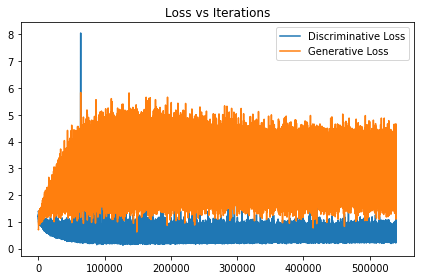

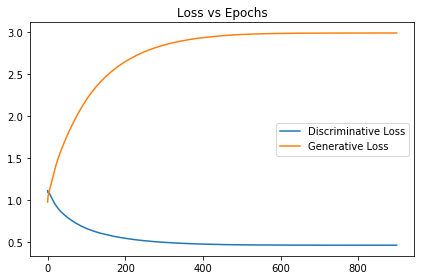

In [13]:
# Plot Graphs
# load()
dloss= train_hist['D_loss'] 
gloss= train_hist['G_loss']
dlossEpoch= train_hist['D_loss_epoch'] 
glossEpoch= train_hist['G_loss_epoch']

tottime = train_hist['total_time'] 

print('Discriminative Loss:', dloss[-1])
print('Generative Loss:', gloss[-1])
print('Time to run ' + str(epochs)+  ' epochs = ' + str(tottime)+'s')

plt.plot(dloss,label='Discriminative Loss')
plt.plot(gloss, label='Generative Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(dlossEpoch,label='Discriminative Loss')
plt.plot(glossEpoch, label='Generative Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.tight_layout()
plt.show()

## Visualizing Outputs from Trained Generative Model

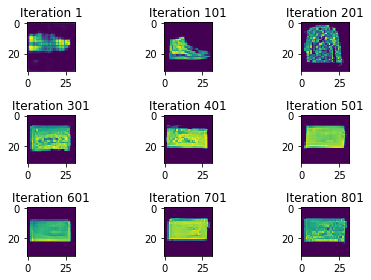

In [35]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][1][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

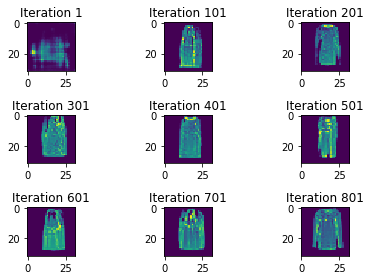

In [36]:
## Label 2
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][2][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

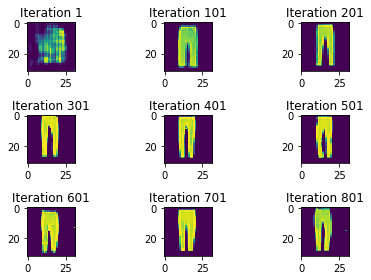

In [37]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][9][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

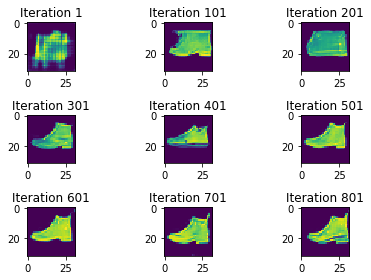

In [38]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][15][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

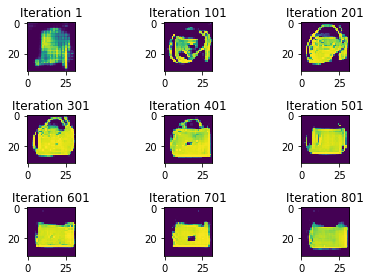

In [39]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][22][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

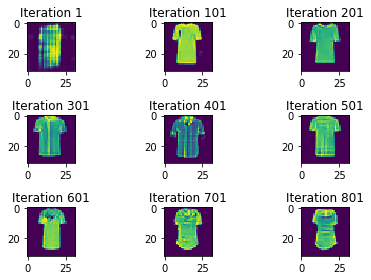

In [40]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][30][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

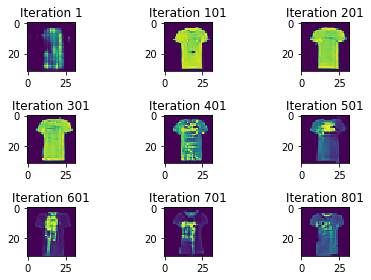

In [41]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][35][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

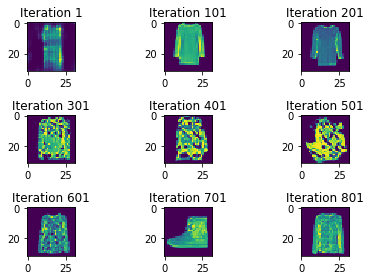

In [42]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][45][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

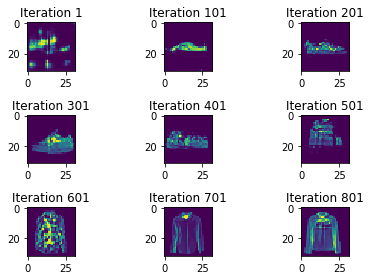

In [43]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][55][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

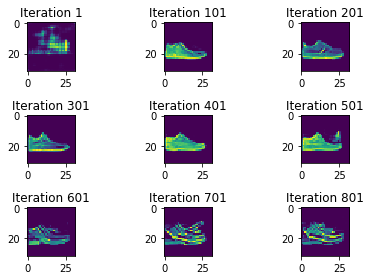

In [44]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][65][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

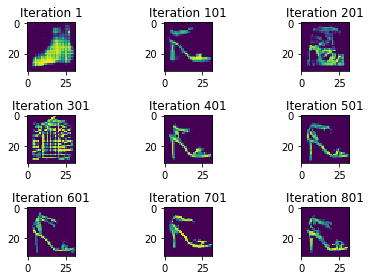

In [45]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][75][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

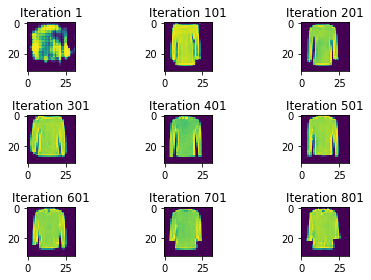

In [46]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][85][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

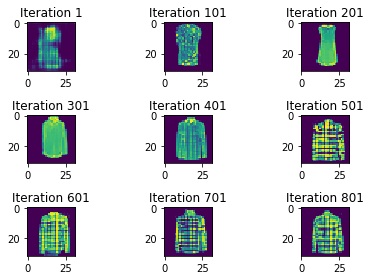

In [48]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][92][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()

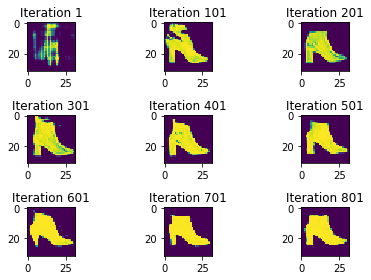

In [49]:
## Label 1
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][98][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+100
plt.tight_layout()
plt.show()